# What does $f(t)$ looks like?

This notebook uses the methods in `scripts/generate_frequency_timeseries.py` to generate some data for different noise settings (i.e. red, white,GWB)

We can then visualise the data that is being fed into the Kalman filter 

## 0. Imports and setup 

In [3]:
import os 
os.environ['TEMPO2'] = '/fred/oz022/tkimpson/tempo2/T2runtime' # set the environment variable
import libstempo

In [17]:

#Modified version of function in generate_frequency_timeseries
def process_pulsar(par_file,tim_file,noise_seed,gwb,psr_alpha,psr_amplitude,efac):

    #Create a pulsar object
    psr = libstempo.tempopulsar(parfile=par_file,timfile=tim_file)   
    print(f'Processing pulsar {psr.name}')

    # Shift the ToAs so that they are exactly aligned with the timing model we loaded
    # For whatever reason doing two passes of make_ideal gets a better result - with just one you can end up with a slight trend in the residuals
    toasim.make_ideal(psr) 
    toasim.make_ideal(psr) 


    # Add noise
    toasim.add_rednoise(psr,psr_amplitude,psr_alpha,seed=noise_seed)     # Add some red noise 
    toasim.add_efac(psr,efac=efac,seed=noise_seed)                       # Add white noise at the level specified in the .tim file. For dataset 1 this is the same for all pulsars. Note that for dataset 2 this is not true - different pulsars have different TOA errs
    gwb.add_gwb(psr,1)                                                   # Add GW background noise. Assumes all pulsars are at 1kpc
    

    #Convert to frequency
    pulsar_emission_times = psr.pets()                                               # PET for Pulsar Emission Time - these are the ToAs in the pulsar frame
    pets                  = (pulsar_emission_times - pulsar_emission_times[0])*86400 # make first time =0, and convert everything to seconds
    pulse_number          = psr.pulsenumbers()                                       # These are the pulse numbers for each ToA --- i.e. the (inferred) absolute phase at each ToA. This is what you really want to use as your phase measurement

    dt    = np.diff(pets) 
    dphi  = np.diff(pulse_number)
    f     = dphi / dt 


    # Assign the time variable. This is when we will think of the f's being evaluated. i.e. the t in f(t) that goes to the Kalman filter
    t = pets[:-1] # i.e. evaluate at t_0 of the dt = t1-t0 interval

    # Also return the secular spin-down
    f_EM = psr['F0'].val + psr['F1'].val*t

    return t,f,f_EM




## 1. Pulsar evolution, no noise 

Lets look at the simplest case. Assume there is no measurement noise, no red noise, no GWB. What does $f(t)$ look like?

In [18]:
import glob 
import libstempo.toasim as toasim
import numpy as np 
def get_frequency_curve(psr_index,seed,gw_amplitude,gw_alpha,psr_alpha,psr_amplitude,efac):

    #Get some data for specific pulsar

    path_to_data = '../mdc/IPTA_Challenge1_open/Challenge_Data/Dataset1/'
    par_file = sorted(glob.glob(path_to_data+'/*.par'))[psr_index]
    tim_file = sorted(glob.glob(path_to_data+'/*.tim'))[psr_index]


    #Create a GWB object which will be shared between pulsars
    # See https://github.com/vallis/libstempo/blob/master/libstempo/toasim.py and https://www.jb.man.ac.uk/~pulsar/Resources/tempo2_examples_ver1.pdf
    gwb = toasim.GWB(ngw=int(1e3),
                     seed=seed,
                     gwAmp=gw_amplitude,
                     alpha=gw_alpha)




    t,f,f_EM = process_pulsar(par_file,
                              tim_file,
                              seed,
                              gwb,
                              psr_alpha,
                              psr_amplitude,
                              efac)

    return t,f,f_EM

In [19]:
psr_index = 1 
seed = 1
gw_amplitude = 0
gw_alpha = -2/3
psr_alpha = 4
psr_amplitude = 0.0
efac = 0.0

t,f,f_EM = get_frequency_curve(psr_index,seed,gw_amplitude,gw_alpha,psr_alpha,psr_amplitude,efac)

/tmp/ipykernel_621811/1193231132.py:5: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  psr = libstempo.tempopulsar(parfile=par_file,timfile=tim_file)


Processing pulsar J0218+4232


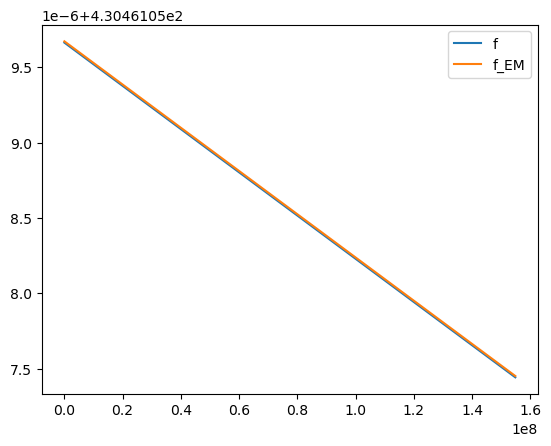

In [20]:
import matplotlib.pyplot as plt

plt.plot(t,f,label='f')
plt.plot(t,f_EM,label='f_EM')
plt.legend()

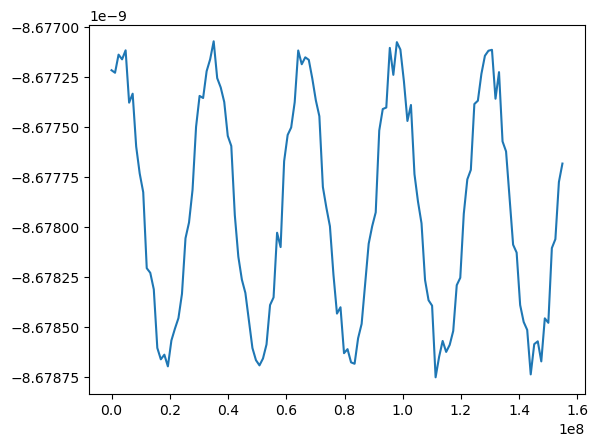

In [21]:
plt.plot(t,f-f_EM)